##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ベイジアンガウス混合モデルとハミルトニアン MCMC

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Bayesian_Gaussian_Mixture_Model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Bayesian_Gaussian_Mixture_Model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"> GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/probability/examples/Bayesian_Gaussian_Mixture_Model.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

この Colab では、TensorFlow Prabability のプリミティブのみを使用してベイジアンガウス混合モデル（BGMM）の事後確率からサンプルを取得する方法を説明します。

## モデル

次元 $D$ ごとの $k\in{1,\ldots, K}$ 混合コンポーネントでは、次のベイジアンガウス混合モデルを使用して $i\in{1,\ldots,N}$ iid サンプルをモデリングします。

$$\begin{align*} \theta &amp;\sim \text{Dirichlet}(\text{concentration}=\alpha_0)\ \mu_k &amp;\sim \text{Normal}(\text{loc}=\mu_{0k}, \text{scale}=I_D)\ T_k &amp;\sim \text{Wishart}(\text{df}=5, \text{scale}=I_D)\ Z_i &amp;\sim \text{Categorical}(\text{probs}=\theta)\ Y_i &amp;\sim \text{Normal}(\text{loc}=\mu_{z_i}, \text{scale}=T_{z_i}^{-1/2})\ \end{align*}$$

`scale` 引数にはすべて、`cholesky` セマンティクスがあります。これは TF Distributions の方法であるため、それを使用します（計算上のメリットにより、一部にこの方法が使用されています）。

ここでも目標は、事後確率からサンプルを生成することです。

$$p\left(\theta, {\mu_k, T_k}*{k=1}^K \Big| {y_i}*{i=1}^N, \alpha_0, {\mu_{ok}}_{k=1}^K\right)$$

${Z_i}_{i=1}^N$ が存在しないところに注目してください。関心があるのは、$N$ でスケーリングしない確率変数のみです。（幸いにも、$Z_i$ の除外を処理する TF 分布があります。）

計算が困難な正規化項のため、この分布から直接サンプリングすることはできません。

正規化が困難な分布からサンプリングするには、[メトロポリスヘイスティングスアルゴリズム](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)を使用することができます。

TensorFlow Probability では、メトロポリスヘイスティングス法に基づくいくつかの手法を含む多数の MCMC オプションが用意されています。このノートブックでは、[ハミルトニアンモンテカルロ法](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo)（`tfp.mcmc.HamiltonianMonteCarlo`）を使用します。HMC は急速に収束することが可能で、（座標的であるのに対し）同時に状態空間をサンプリングし、TF の美徳の 1 つである自動微分を利用するため、ほとんどにおいて適切なオプションです。それを踏まえると、BGMM 事後確率からのサンプリングは実際、[ギブスサンプリング](https://en.wikipedia.org/wiki/Gibbs_sampling)などの他のアプローチよりも優れている場合があります。

In [ ]:
%matplotlib inline


import functools

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import seaborn as sns; sns.set_context('notebook')

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

実際にモデルを構築する前に、新しいタイプの分布を定義する必要があります。上記のモデルの仕様から、逆共分散行列、つまり「精度行列」(https://en.wikipedia.org/wiki/Precision_(statistics%29) を使って MVN をパラメータ化することは明らかです。これを TF で行うには、`Bijector` を使用する必要があります。この `Bijector` は前方変換を使用します。

- `Y =  tf.linalg.triangular_solve((tf.linalg.matrix_transpose(chol_precision_tril), X, adjoint=True) + loc`

また、`log_prob` 計算は、次のように単に逆になります。

- `X = tf.linalg.matmul(chol_precision_tril, X - loc, adjoint_a=True)`

HMC に必要なのは `log_prob` だけであるため、つまり、`tf.linalg.triangular_solve` を絶対に呼び出さないようにします（`tfd.MultivariateNormalTriL` の場合と同じように）。`tf.linalg.matmul` はキャッシュロイヤリティに優れていることから、通常は高速で行われるため、これは有利です。


In [ ]:
class MVNCholPrecisionTriL(tfd.TransformedDistribution):
  """MVN from loc and (Cholesky) precision matrix."""

  def __init__(self, loc, chol_precision_tril, name=None):
    super(MVNCholPrecisionTriL, self).__init__(
        distribution=tfd.Independent(tfd.Normal(tf.zeros_like(loc),
                                                scale=tf.ones_like(loc)),
                                     reinterpreted_batch_ndims=1),
        bijector=tfb.Chain([
            tfb.Shift(shift=loc),
            tfb.Invert(tfb.ScaleMatvecTriL(scale_tril=chol_precision_tril,
                                           adjoint=True)),
        ]),
        name=name)

`tfd.Independent` 分布はある分布の独立したドローを統計的に独立した座標を使った多変量分布に変換します。`log_prob` の計算の観点では、この「メタ分布」はイベント次元の単純な和として表されます。

また、スケール行列の `adjoint`（「転置」）を取っていることにも注目してください。これは、精度が共分散である場合、すなわち $P=C^{-1}$ であり、$C=AA^\top$ である場合に $P=BB^{\top}$ where $B=A^{-\top}$ となるためです。

この分布にはそれとなくコツがいるため、思った通りに `MVNCholPrecisionTriL` が動作することをさっと検証しましょう。

In [ ]:
def compute_sample_stats(d, seed=42, n=int(1e6)):
  x = d.sample(n, seed=seed)
  sample_mean = tf.reduce_mean(x, axis=0, keepdims=True)
  s = x - sample_mean
  sample_cov = tf.linalg.matmul(s, s, adjoint_a=True) / tf.cast(n, s.dtype)
  sample_scale = tf.linalg.cholesky(sample_cov)
  sample_mean = sample_mean[0]
  return [
      sample_mean,
      sample_cov,
      sample_scale,
  ]

dtype = np.float32
true_loc = np.array([1., -1.], dtype=dtype)
true_chol_precision = np.array([[1., 0.],
                                [2., 8.]],
                               dtype=dtype)
true_precision = np.matmul(true_chol_precision, true_chol_precision.T)
true_cov = np.linalg.inv(true_precision)

d = MVNCholPrecisionTriL(
    loc=true_loc,
    chol_precision_tril=true_chol_precision)

[sample_mean, sample_cov, sample_scale] = [
    t.numpy() for t in compute_sample_stats(d)]

print('true mean:', true_loc)
print('sample mean:', sample_mean)
print('true cov:\n', true_cov)
print('sample cov:\n', sample_cov)

true mean: [ 1. -1.]
sample mean: [ 1.0002806 -1.000105 ]
true cov:
 [[ 1.0625   -0.03125 ]
 [-0.03125   0.015625]]
sample cov:
 [[ 1.0641273  -0.03126175]
 [-0.03126175  0.01559312]]


サンプルの平均と共分散が真の平均と共分散に近いため、分布は適切に実装されているようです。次に、`MVNCholPrecisionTriL` `tfp.distributions.JointDistributionNamed` を使用して、BGMM モデルを指定します。観測モデルでは、`tfd.MixtureSameFamily` を使用して、自動的に ${Z_i}_{i=1}^N$ ドローを統合します。

In [ ]:
dtype = np.float64
dims = 2
components = 3
num_samples = 1000

In [ ]:
bgmm = tfd.JointDistributionNamed(dict(
  mix_probs=tfd.Dirichlet(
    concentration=np.ones(components, dtype) / 10.),
  loc=tfd.Independent(
    tfd.Normal(
        loc=np.stack([
            -np.ones(dims, dtype),
            np.zeros(dims, dtype),
            np.ones(dims, dtype),
        ]),
        scale=tf.ones([components, dims], dtype)),
    reinterpreted_batch_ndims=2),
  precision=tfd.Independent(
    tfd.WishartTriL(
        df=5,
        scale_tril=np.stack([np.eye(dims, dtype=dtype)]*components),
        input_output_cholesky=True),
    reinterpreted_batch_ndims=1),
  s=lambda mix_probs, loc, precision: tfd.Sample(tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(probs=mix_probs),
      components_distribution=MVNCholPrecisionTriL(
          loc=loc,
          chol_precision_tril=precision)),
      sample_shape=num_samples)
))

In [ ]:
def joint_log_prob(observations, mix_probs, loc, chol_precision):
  """BGMM with priors: loc=Normal, precision=Inverse-Wishart, mix=Dirichlet.

  Args:
    observations: `[n, d]`-shaped `Tensor` representing Bayesian Gaussian
      Mixture model draws. Each sample is a length-`d` vector.
    mix_probs: `[K]`-shaped `Tensor` representing random draw from
      `Dirichlet` prior.
    loc: `[K, d]`-shaped `Tensor` representing the location parameter of the
      `K` components.
    chol_precision: `[K, d, d]`-shaped `Tensor` representing `K` lower
      triangular `cholesky(Precision)` matrices, each being sampled from
      a Wishart distribution.

  Returns:
    log_prob: `Tensor` representing joint log-density over all inputs.
  """
  return bgmm.log_prob(
      mix_probs=mix_probs, loc=loc, precision=chol_precision, s=observations)

## 「トレーニング」データを生成する

このデモでは、いくつかのランダムデータをサンプリングします。

In [ ]:
true_loc = np.array([[-2., -2],
                     [0, 0],
                     [2, 2]], dtype)
random = np.random.RandomState(seed=43)

true_hidden_component = random.randint(0, components, num_samples)
observations = (true_loc[true_hidden_component] +
                random.randn(num_samples, dims).astype(dtype))

## HMC を使用したベイジアン推論

TFD を使用してモデルを指定し、観測データを取得したので、HMC を実行するために必要な材料がすべて揃いました。

これを行うには、サンプリングしないものを「突き止める」ために[部分適用](https://en.wikipedia.org/wiki/Partial_application)を使用します。この場合は、`observations` のみを突き止める必要があります。（ハイパーパラメータは `joint_log_prob` 関数シグネチャの一部ではなく、前の分布にすでにベイクされています。）

In [ ]:
unnormalized_posterior_log_prob = functools.partial(joint_log_prob, observations)

In [ ]:
initial_state = [
    tf.fill([components],
            value=np.array(1. / components, dtype),
            name='mix_probs'),
    tf.constant(np.array([[-2., -2],
                          [0, 0],
                          [2, 2]], dtype),
                name='loc'),
    tf.linalg.eye(dims, batch_shape=[components], dtype=dtype, name='chol_precision'),
]

### 制約のない表現

ハミルトニアンモンテカルロ法（HMC）では、ターゲットの対数確率関数がその引数に関して微分可能である必要があります。さらに、HMC は、状態空間が制約されていない場合に、はるかに高い有効性を見せることがあります。

つまり、BGMM 事後確率からサンプリングする場合には、大きく 2 つの問題を対処する必要があるということになります。

1. $\theta$ は離散確率ベクトルを表すため、$\sum_{k=1}^K \theta_k = 1$ と $\theta_k&gt;0$ である必要があります。
2. $T_k$ は可逆共分散行列を表すため、$T_k \succ 0$、すなわち[正定値](https://en.wikipedia.org/wiki/Positive-definite_matrix)である必要があります。


この要件を解決するには、次のことを行う必要があります。

1. 制約された変数を制約のない空間に変換する
2. 制約のない空間で MCMC を実行する
3. 制約のない変数を制約された空間に変換する

`MVNCholPrecisionTriL` と同様に、確率変数を制約のない空間に変換するには、[`Bijector`](https://www.tensorflow.org/api_docs/python/tf/distributions/bijectors/Bijector) を使用します。

- [`Dirichlet`](https://en.wikipedia.org/wiki/Dirichlet_distribution) は [ソフトマックス関数](https://en.wikipedia.org/wiki/Softmax_function)を通じて制約のない空間に変換されます。

- 精度確率変数は、半正定値行列の分布です。これらの制約を解くには、`FillTriangular` と `TransformDiagonal` bijector を使用します。これらはベクトルを下三角行列に変換し、対角線が正であるようにします。前者は、$d^2$ ではなく、$d(d+1)/2$ 浮動小数のみのサンプリングを可能にするため、有用です。

In [ ]:
unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.Identity(),
    tfb.Chain([
        tfb.TransformDiagonal(tfb.Softplus()),
        tfb.FillTriangular(),
    ])]

In [ ]:
@tf.function(autograph=False)
def sample():
  return tfp.mcmc.sample_chain(
    num_results=2000,
    num_burnin_steps=500,
    current_state=initial_state,
    kernel=tfp.mcmc.SimpleStepSizeAdaptation(
        tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_posterior_log_prob,
                 step_size=0.065,
                 num_leapfrog_steps=5),
            bijector=unconstraining_bijectors),
         num_adaptation_steps=400),
    trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

[mix_probs, loc, chol_precision], is_accepted = sample()

ここで、チェーンを実行し、事後の平均を出力します。

In [ ]:
acceptance_rate = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32)).numpy()
mean_mix_probs = tf.reduce_mean(mix_probs, axis=0).numpy()
mean_loc = tf.reduce_mean(loc, axis=0).numpy()
mean_chol_precision = tf.reduce_mean(chol_precision, axis=0).numpy()
precision = tf.linalg.matmul(chol_precision, chol_precision, transpose_b=True)


In [ ]:
print('acceptance_rate:', acceptance_rate)
print('avg mix probs:', mean_mix_probs)
print('avg loc:\n', mean_loc)
print('avg chol(precision):\n', mean_chol_precision)

acceptance_rate: 0.5305
avg mix probs: [0.25248723 0.60729516 0.1402176 ]
avg loc:
 [[-1.96466753 -2.12047249]
 [ 0.27628865  0.22944732]
 [ 2.06461244  2.54216122]]
avg chol(precision):
 [[[ 1.05105032  0.        ]
  [ 0.12699955  1.06553113]]

 [[ 0.76058015  0.        ]
  [-0.50332767  0.77947431]]

 [[ 1.22770457  0.        ]
  [ 0.70670027  1.50914164]]]


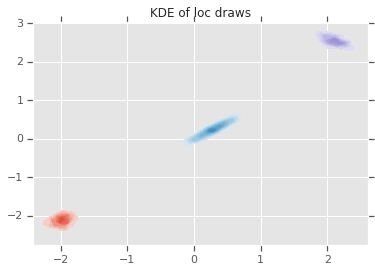

In [ ]:
loc_ = loc.numpy()
ax = sns.kdeplot(loc_[:,0,0], loc_[:,0,1], shade=True, shade_lowest=False)
ax = sns.kdeplot(loc_[:,1,0], loc_[:,1,1], shade=True, shade_lowest=False)
ax = sns.kdeplot(loc_[:,2,0], loc_[:,2,1], shade=True, shade_lowest=False)
plt.title('KDE of loc draws');

## 結論

この単純な Colab では、TensorFlow Probability のプリミティブを使用して階層的ベイジアン混合モデルを構築する方法を説明しました。